In [1]:
cd ..

c:\Users\seand\OneDrive\Dokumente\Masterthesis\StarBoundaryNetworks\src


In [2]:
import torch
from torch.autograd.functional import hessian
from torch import nn
from tqdm import tqdm

from domains.starDomain import Sphere
from radialFunctions.radialFunctions import linearRadial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from scipy.interpolate import griddata
from ipywidgets import *
import numpy as np
#%matplotlib notebook
%matplotlib widget

# Define Problem

$u_xx(x,y) + u_yy(x,y) = sin(xy)$ on unit sphere

and boundary condition $u(x,y) = x+y$ on boundary of sphere

## Define Loss funciton

In [3]:
def laplacian(f, input):
    dim = input.shape[1]
    batchSize = input.shape[0]
    outf = f(input)
    laplacian = torch.zeros(batchSize, dtype=float, requires_grad=True)


    

    dx = torch.autograd.grad(outf, input, torch.ones((batchSize, 1), requires_grad=True), create_graph=True)[0]

    for i in range(dim):
        d2x = torch.autograd.grad((dx[:,i]).view(-1,1), input, torch.ones((batchSize, 1), requires_grad=True), create_graph=True)[0][:,i]
        laplacian = laplacian + d2x



    return laplacian.view(-1,1)
    


In [4]:
#define PINN loss function for problem from above:
def pinnLossPoissonSin(u, xy_grid):
  laplacian_u = laplacian(u, xy_grid)
  #ignore non differentiable points
  maskWhereNotNan = laplacian_u.view(-1).isnan() == False
  laplacian_u_cleaned = laplacian_u[maskWhereNotNan]
  dataFunciton = 0#torch.sin(xy_grid[maskWhereNotNan,0] * xy_grid[maskWhereNotNan, 1])

  return torch.mean( torch.abs(laplacian_u_cleaned - dataFunciton).view(-1,1)  )  , laplacian_u


In [5]:
#define PINN loss function for problem from above with boundary condition:
def pinnLossPoissonSinWithBoundary(u, xy_grid, boundaryGrid, alpha = 1, beta = 0.1):#, device = 'cuda'):
    laplacian_u = laplacian(u, xy_grid)
    #ignore non differentiable points
    maskWhereNotNan = laplacian_u.view(-1).isnan() == False
    laplacian_u_cleaned = laplacian_u[maskWhereNotNan]

    uOnBoundary = u(boundaryGrid)

    expectedBoundaryValue = (boundaryGrid[:,0] + boundaryGrid[:,1]).view(-1,1)

    return alpha * torch.mean( torch.abs(laplacian_u_cleaned - torch.sin(xy_grid[maskWhereNotNan,0] * xy_grid[maskWhereNotNan, 1]).view(-1,1)  )  ) + beta * torch.mean(torch.abs(uOnBoundary - expectedBoundaryValue )), laplacian_u


In [6]:
#Example on how to use laplacian
grid = torch.arange(10, dtype=float, requires_grad=True).view(-1,2)
def f(grid):
    x1 = grid[:, 0]
    x2 = grid[:, 1]
    return (x1*x1*x2*x2).view(-1,1)

laplacian(f, grid)

tensor([[  2.],
        [ 26.],
        [ 82.],
        [170.],
        [290.]], dtype=torch.float64, grad_fn=<ViewBackward0>)

# Define Neural Network without imposed BC

In [7]:
class PINNModel(nn.Module):
  def __init__(self, n_hidden, n_layers):
    super().__init__()
    self.activation_func = nn.Tanh
    self.in_layer = nn.Sequential(*[nn.Linear(2,n_hidden) , self.activation_func()])
    self.hid_layers = nn.Sequential(*[
        nn.Sequential(*[
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh()
            ])
        for i in range(n_layers)], nn.Linear(n_hidden, n_hidden))
    self.out_layer = nn.Linear(n_hidden,1)

 
  
  def forward(self, input):
    x = input + 0
   
    x = self.in_layer(x)
   
    x = self.hid_layers(x)
   
    x = self.out_layer(x)
   

    return x

# Define Neural Network with imposed BC

In [8]:
class ImposedBCPINNSphere2D(nn.Module):
  def __init__(self, n_hidden, n_layers):
    super().__init__()
    self.activation_func = nn.Tanh
    self.in_layer = nn.Sequential(*[nn.Linear(2,n_hidden)])# , self.activation_func()])
    self.hid_layers = nn.Sequential(*[
        nn.Sequential(*[
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh()
            ])
        for i in range(n_layers)], nn.Linear(n_hidden, n_hidden))
    self.out_layer = nn.Linear(n_hidden,1)
    self.domain = Sphere(2, torch.tensor((0.,0.)), torch.tensor(1.))
    self.radialDecayFunciton = linearRadial
  

  def boundaryCondition(self, input):
    return input[:,0] + input[:,1]
  
  def boundaryConditionSpherical(self, angles):
    return self.boundaryCondition(self.domain.getCartesianCoordinates( self.domain.radiusDomainFunciton(angles) ,angles))
  
  def zeroOnBoundaryExtension(self, input):
    radius, angles = self.domain.getSphericalCoordinates(input)
    return self.radialDecayFunciton( radius / self.domain.radiusDomainFunciton(angles)).view(-1,1)
  
  def DCBoundaryExtension(self, input):
    radius, angles = self.domain.getSphericalCoordinates(input)
    return (self.boundaryConditionSpherical( angles) *  (1- self.radialDecayFunciton( radius / self.domain.radiusDomainFunciton(angles)))).view(-1,1)
  
  def forward(self, input):
    x = input + 0
   
    x = self.in_layer(x)
   
    x = self.hid_layers(x)
   
    x = self.out_layer(x)
   

    return x*self.zeroOnBoundaryExtension(input) + self.DCBoundaryExtension(input)

# Generate Training Data

In [9]:
#generate Points for training
sphereForPoints  = Sphere(2,torch.tensor([0.0,0.0]), torch.tensor(1.))
spherePoints = sphereForPoints.generateCartesianRandomPointsFullDomain(10000)


In [10]:
spherePoints

tensor([[-0.3495,  0.0400],
        [ 0.7597,  0.2092],
        [-0.6151,  0.0950],
        ...,
        [-0.6918,  0.0155],
        [ 0.1191,  0.8319],
        [-0.3783,  0.3188]])

In [11]:
pointsOnBoundary = sphereForPoints.generateSphericalRandomPointsOnBoundary(1000)

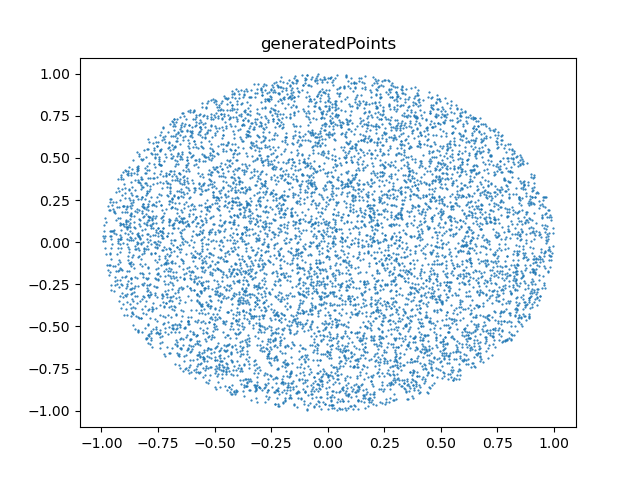

In [12]:
#plot generated points
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.set_title('generatedPoints')
ax1.scatter(spherePoints[:,0],spherePoints[:,1],s = 0.3)
plt.show()

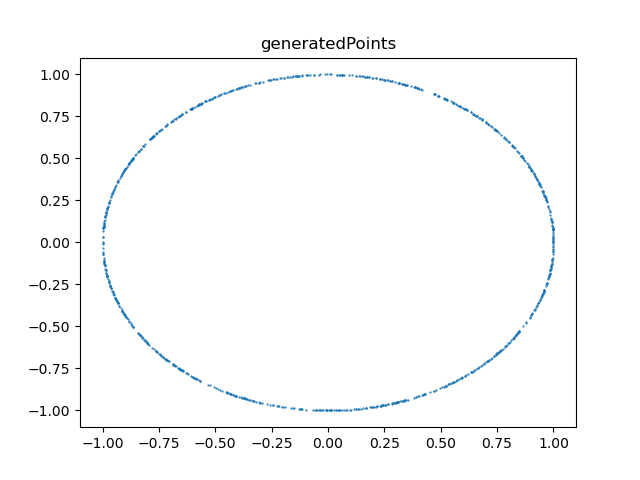

In [13]:
#plot generated points
fig1b = plt.figure()
ax1b = fig1b.add_subplot(1,1,1)
ax1b.set_title('generatedPoints')
ax1b.scatter(pointsOnBoundary[:,0],pointsOnBoundary[:,1],s = 0.3)
plt.show()

# Train NN with imposed BC

In [18]:
#define Trainingset, epochs, lr:
xy_grid = spherePoints
xy_grid.requires_grad = True
epochs = 100
learningRate  = 1e-2

In [19]:
#define model:
solPDE = ImposedBCPINNSphere2D( 1000, 4)

In [20]:
#define optimizer
optimizer = torch.optim.Adam(solPDE.parameters(), lr = learningRate)

In [21]:
#computes initial loss to see where we start
loss, points = pinnLossPoissonSin(solPDE, xy_grid )
loss

tensor(0.0740, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [22]:
#training
for i in range(epochs):
  optimizer.zero_grad()
 
  loss,_ = pinnLossPoissonSin(solPDE, xy_grid )
  #if i%100 == 0:
  print(loss.item())
  loss.backward(retain_graph=True)
  optimizer.step()


0.0739592047302889
7.245668582023374
1245.9516549064856
96.53122900871006
70.5250350546897
23.204155003763404
29.892546900572768
36.14738743066624
25.785368835058204
60.081214440367226
58.643838139792734
19.980042705959264
13.327117138588019
71.12009082421524
68.01680984362886
13.608021078983418
8.734408816072396
73.19989022202871
68.9998979492751
10.400952016337973
6.234713941990894
70.83541506947334
66.64272675783263
7.920283099499451
4.427711900889994
66.33863539704579
62.23722734819612
6.017353016764709
3.02953630637975
60.7805599250788
56.95039507547858
4.346738430125428
1.7895028541612392
54.850324107659574
51.36519120956612
2.8190952513349776
0.6513897730699804
48.902205056412924
45.78434183653539
1.436417139230808
0.37257360594330224
39.30570094391579
33.72152956446154
9.487024762311934
10.154396388881128
24.458327697632384
20.449681016892114
15.45887660408768
15.406361245518568
14.262413935712402
11.42075865485035
18.09680520969121
17.615338275074883
7.396042566902015
5.418740

In [101]:
# Compute loss aftre training at single points
laplacian_u = laplacian(solPDE, xy_grid)
lossOnGrid = laplacian_u - torch.sin(xy_grid[:,0] * xy_grid[:, 1]).view(-1,1)

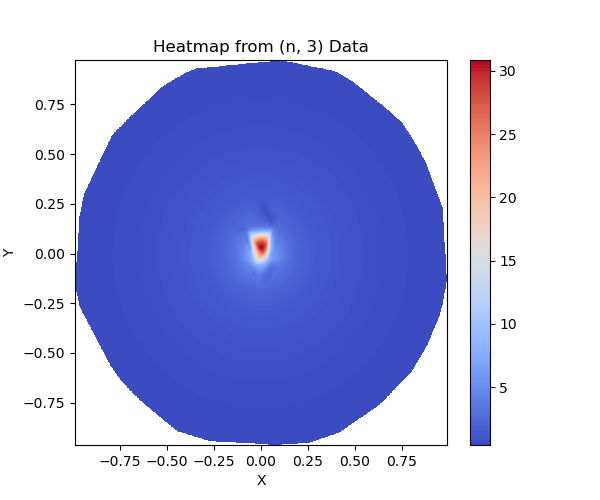

In [102]:
# Plot losses on training data points as heatmap

sampleSizeForDrawing = 1000
data = np.empty((sampleSizeForDrawing,3))
data[:,0] = xy_grid[:sampleSizeForDrawing,0].detach().numpy()
data[:,1] = xy_grid[:sampleSizeForDrawing,1].detach().numpy()
data[:,2] = lossOnGrid[:sampleSizeForDrawing].view(-1).detach().numpy()

# Create a meshgrid to interpolate over (choose grid resolution as needed)
grid_x, grid_y = np.mgrid[min(data[:, 0]):max(data[:, 0]):1000j, 
                          min(data[:, 1]):max(data[:, 1]):1000j]

# Interpolate the z values over the grid
grid_z = griddata((data[:, 0], data[:, 1]), data[:, 2], (grid_x, grid_y), method='cubic')



# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.pcolormesh(grid_x, grid_y, grid_z, cmap='coolwarm', shading='auto')
plt.colorbar()  # Add colorbar to the side
plt.title("Heatmap from (n, 3) Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


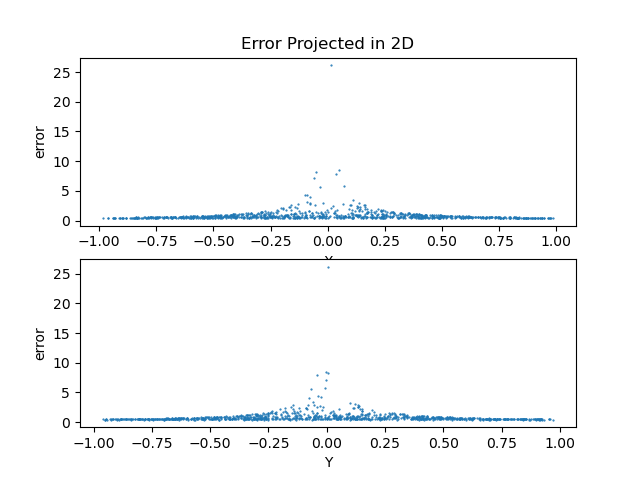

In [103]:
# Plot projected losses on xz and yz planes to see where "problems" happen

maxError = torch.inf
maskSmallerError = data[:,2]<maxError
fig5,ax5 = plt.subplots(2,1)#plt.figure()

ax5[0].set_title('Error Projected in 2D')
ax5[0].set_xlabel('X')
ax5[0].set_ylabel('error')


ax5[1].set_xlabel('Y')
ax5[1].set_ylabel('error')

ax5[0].scatter(data[maskSmallerError,0], data[maskSmallerError,2], s= 0.3)
ax5[1].scatter(data[maskSmallerError,1], data[maskSmallerError,2], s= 0.3)
plt.show()

C:\Users\seand\AppData\Local\Temp\ipykernel_15756\3043282009.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z, cmap='viridis')


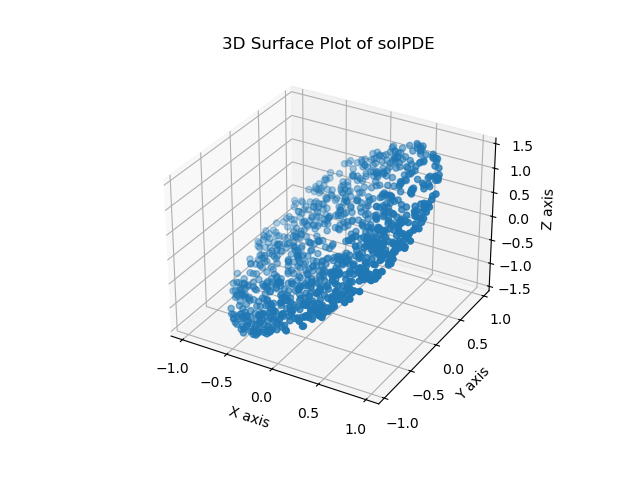

In [104]:

numPointsPlot = 1000
x = xy_grid[:numPointsPlot,0].view(-1).detach().numpy()
y = xy_grid[:numPointsPlot,1].view(-1).detach().numpy()
#X = x.tile((numPointsPlot,1)).detach().numpy()
#Y = y.view(-1,1).tile((1, numPointsPlot)).detach().numpy()
# Create a grid of x and y values
#x = np.linspace(0, 5, 5)
#y = np.linspace(0, 5, 5)
#X, Y = np.meshgrid(x, y)

# Compute Z values using the function f(x, y)
z = solPDE(xy_grid[:numPointsPlot]).view(-1).detach().numpy()

# Create a 3D plot
fig6 = plt.figure()
ax6 = fig6.add_subplot(111, projection='3d')

# Plot the surface
ax6.scatter(x, y, z, cmap='viridis')

# Add labels and title
ax6.set_xlabel('X axis')
ax6.set_ylabel('Y axis')
ax6.set_zlabel('Z axis')
ax6.set_title('3D Surface Plot of solPDE')

# Show plot
plt.show()


there seems to be a sharp corner at y = 0

# Train NN without imposed BC

In [105]:
#define Trainingset, epochs, lr:
xy_grid = spherePoints
xy_grid.requires_grad = True
boundaryGrid = pointsOnBoundary
epochs = 100
learningRate  = 1e-2

In [106]:
#define model:
regularPINN = PINNModel( 1000, 3)

In [107]:
#define optimizer
optimizer = torch.optim.Adam(regularPINN.parameters(), lr = learningRate)

In [108]:
#computes initial loss to see where we start
loss, points = pinnLossPoissonSinWithBoundary(regularPINN, xy_grid, boundaryGrid )
loss

tensor(0.2482, dtype=torch.float64, grad_fn=<AddBackward0>)

In [109]:
#training
for i in range(epochs):
  optimizer.zero_grad()
 
  loss,_ = pinnLossPoissonSinWithBoundary(regularPINN, xy_grid , boundaryGrid, beta=1)
  #if i%100 == 0:
  print(loss.item())
  loss.backward(retain_graph=True)
  optimizer.step()


1.0549606846588286
28.45173839959032
2948.4316101348522
800.5110722127179
25.79853187947013
16.621707871601842
15.842794013369764
21.048884456530793
16.721916888206334
1.3737530538804328
17.266147777795723
17.22977730679124
1.414196666803643
11.085199347122867
1.101947369932908
10.40627237542838
4.0742738050609475
7.337407785148154
7.94482194075173
4.314634359904329
11.574395529890253
1.486966360571811
8.810618745878028
10.787106815609391
1.166552676099246
1.4029121469087167
18.759511300278614
5.795253099016234
37.46656968313129
45.02025616593257
20.305765141337883
34.0309121739544
50.98081447664614
34.3273956788011
12.908296053959539
23.25914939285907
1.108798620452127
28.639428087304253
22.382007778196908
15.835846786215436
17.688104723252884
13.10868605334286
8.382868501492835
28.215917792843605
28.83433000403634
2.8125041416919787
1.2824456246498408
11.987389282604415
8.697405552016392
5.128107448285386
14.791503976164332
1.0996823336156252
21.051494584050545
8.41937703407172
35.00

In [110]:
# Compute loss aftre training at single points
laplacian_u = laplacian(regularPINN, xy_grid)
lossOnGrid = torch.abs(laplacian_u - torch.sin(xy_grid[:,0] * xy_grid[:, 1]).view(-1,1))

lossOnBoundary = torch.abs(regularPINN(boundaryGrid) - (boundaryGrid[:,0] + boundaryGrid[:,1]).view(-1,1))

totalGrid = torch.cat((xy_grid, boundaryGrid), 0)
allLoss = torch.cat((lossOnGrid, lossOnBoundary),0).view(-1)



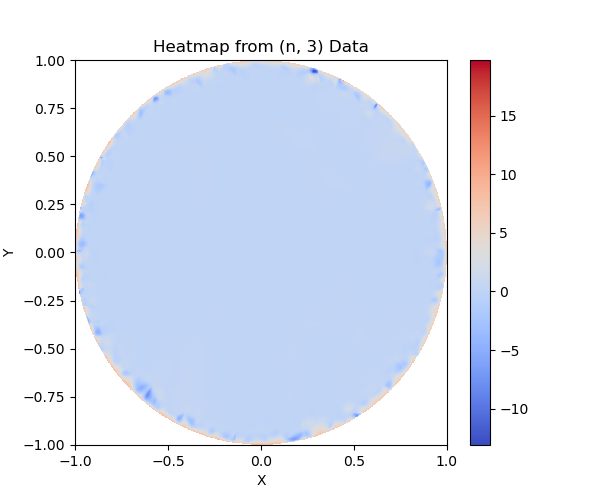

In [111]:
# Plot losses on training data points as heatmap

sampleSizeForDrawing = 3000
pickMask = torch.randint(0,allLoss.shape[0], (sampleSizeForDrawing,))
data = np.empty((sampleSizeForDrawing,3))
data[:,0] = totalGrid[pickMask,0].detach().numpy()
data[:,1] = totalGrid[pickMask,1].detach().numpy()
data[:,2] = allLoss[pickMask].view(-1).detach().numpy()

# Create a meshgrid to interpolate over (choose grid resolution as needed)
grid_x, grid_y = np.mgrid[min(data[:, 0]):max(data[:, 0]):1000j, 
                          min(data[:, 1]):max(data[:, 1]):1000j]

# Interpolate the z values over the grid
grid_z = griddata((data[:, 0], data[:, 1]), data[:, 2], (grid_x, grid_y), method='cubic')



# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.pcolormesh(grid_x, grid_y, grid_z, cmap='coolwarm', shading='auto')
plt.colorbar()  # Add colorbar to the side
plt.title("Heatmap from (n, 3) Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

C:\Users\seand\AppData\Local\Temp\ipykernel_15756\1868684707.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z1, cmap='viridis',c = 'blue')
C:\Users\seand\AppData\Local\Temp\ipykernel_15756\1868684707.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z2, cmap='viridis',c = 'red')


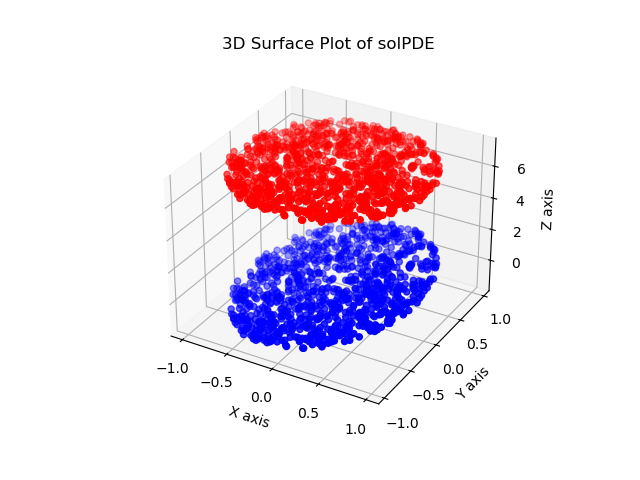

In [112]:
numPointsPlot = 1000
x = xy_grid[:numPointsPlot,0].view(-1).detach().numpy()
y = xy_grid[:numPointsPlot,1].view(-1).detach().numpy()
#X = x.tile((numPointsPlot,1)).detach().numpy()
#Y = y.view(-1,1).tile((1, numPointsPlot)).detach().numpy()
# Create a grid of x and y values
#x = np.linspace(0, 5, 5)
#y = np.linspace(0, 5, 5)
#X, Y = np.meshgrid(x, y)

# Compute Z values using the function f(x, y)
z1 = solPDE(xy_grid[:numPointsPlot]).view(-1).detach().numpy()
z2 = regularPINN(xy_grid[:numPointsPlot]).view(-1).detach().numpy()

# Create a 3D plot
fig6 = plt.figure()
ax6 = fig6.add_subplot(111, projection='3d')

# Plot the surface
ax6.scatter(x, y, z1, cmap='viridis',c = 'blue')
ax6.scatter(x, y, z2, cmap='viridis',c = 'red')

# Add labels and title
ax6.set_xlabel('X axis')
ax6.set_ylabel('Y axis')
ax6.set_zlabel('Z axis')
ax6.set_title('3D Surface Plot of solPDE')

# Show plot
plt.show( )
